# Import and load Detectron2 and libraries

In [1]:
#%env CUDA_DEVICE_ORDER=PCI_BUS_ID
#%env CUDA_VISIBLE_DEVICES={2,3}
import torch, torchvision
torch.cuda.set_device(1)

torch.__version__

'1.3.1'

In [2]:
!nvidia-smi

Tue Feb 11 11:23:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   45C    P0    59W / 149W |   1698MiB / 11441MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:07:00.0 Off |                    0 |
| N/A   26C    P8    31W / 149W |     11MiB / 11441MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
%load_ext autoreload
%autoreload 2
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from operator import itemgetter

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt


Register the dataset to detectron2, following the detectron2 custom dataset tutorial. Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.

If your dataset is already in the COCO format, you can simply register it by

from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset", {}, "json_annotation.json", "path/to/image/dir")




# Load and inspect our data

In [22]:
import os
import numpy as np
import pickle
from detectron2.structures import BoxMode

def get_lofar_dicts(annotation_filepath):
    with open(annotation_filepath, "rb") as f:
        dataset_dicts = pickle.load(f)
    new_data =[]
    for i in range(len(dataset_dicts)):
        for ob in dataset_dicts[i]['annotations']:
            ob['bbox_mode'] = BoxMode.XYXY_ABS
        if dataset_dicts[i]['file_name'].endswith('_rotated0deg.png'):
            new_data.append(dataset_dicts[i])
    return new_data

DATASET_NAME= "LGZ_v8"
base_path = f"/data/mostertrij/data/frcnn_images/LGZ_v5_more_rotations/LGZ_COCOstyle/annotations/"

In [5]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val", "test"]:
    DatasetCatalog.register(f"{DATASET_NAME}_" + d, 
                            lambda d=d: get_lofar_dicts(os.path.join(base_path,f"VIA_json_{d}.pkl")))
    MetadataCatalog.get(f"{DATASET_NAME}_" + d).set(thing_classes=["radio_source"])
lofar_metadata = MetadataCatalog.get(f"{DATASET_NAME}_train")

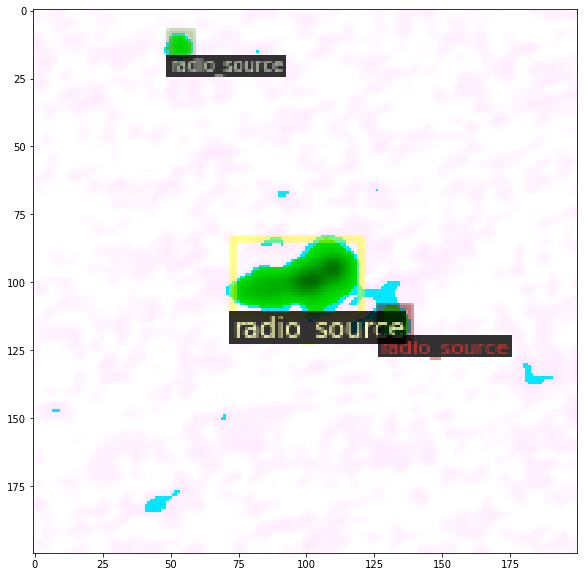

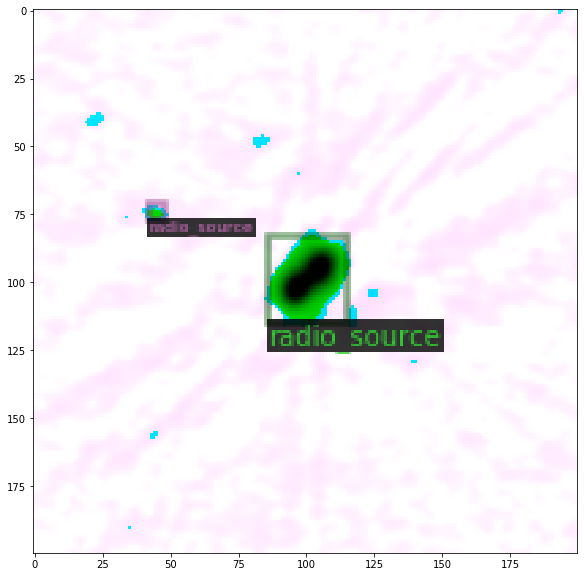

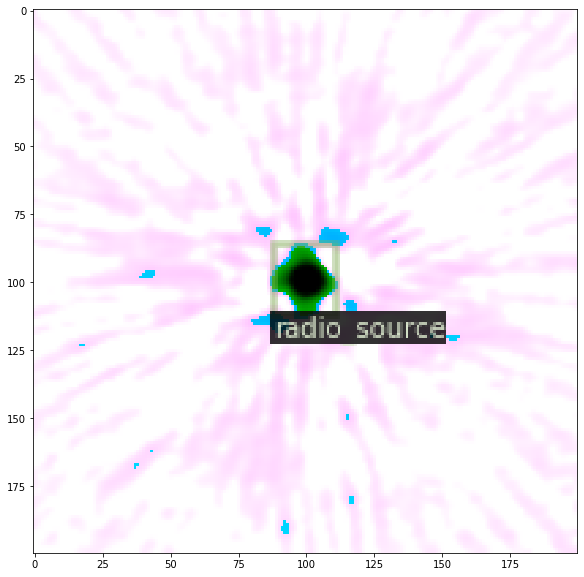

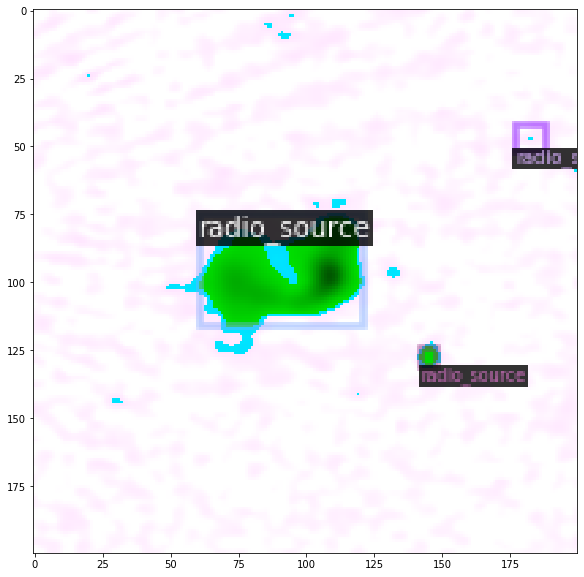

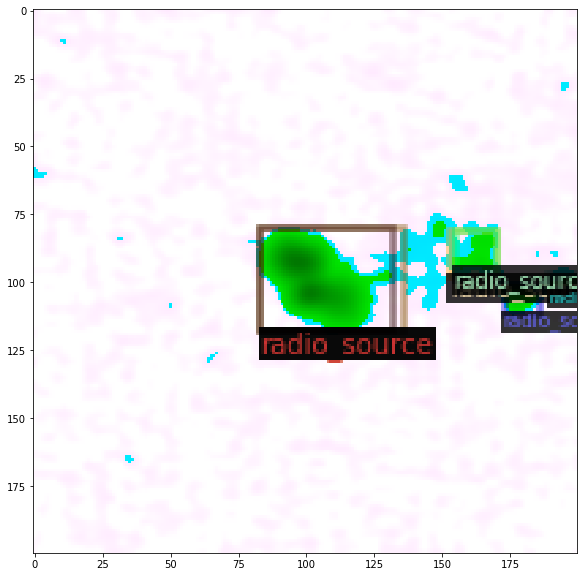

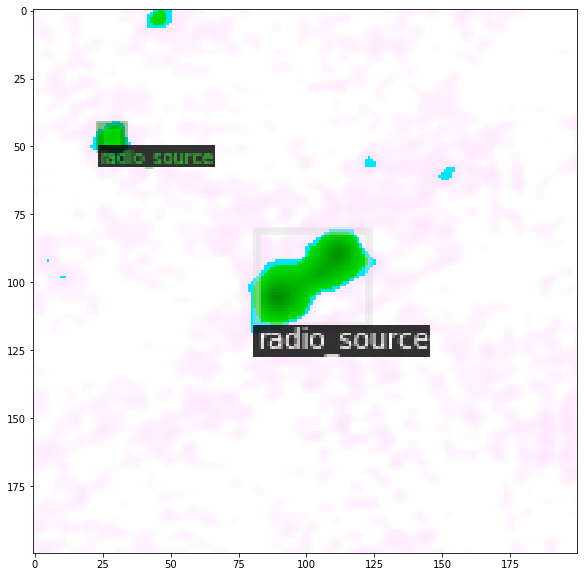

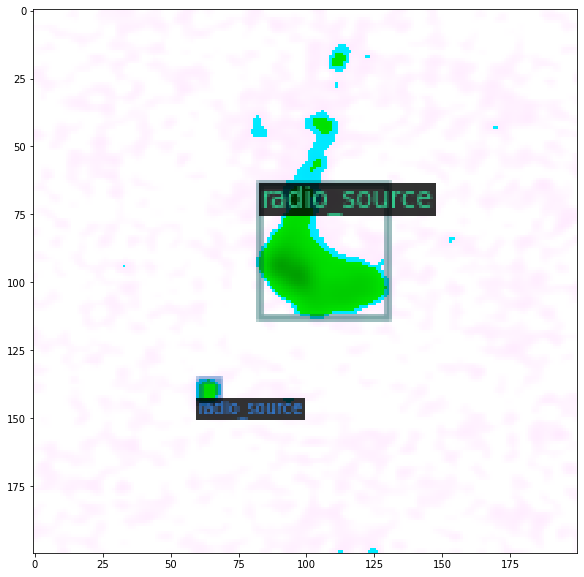

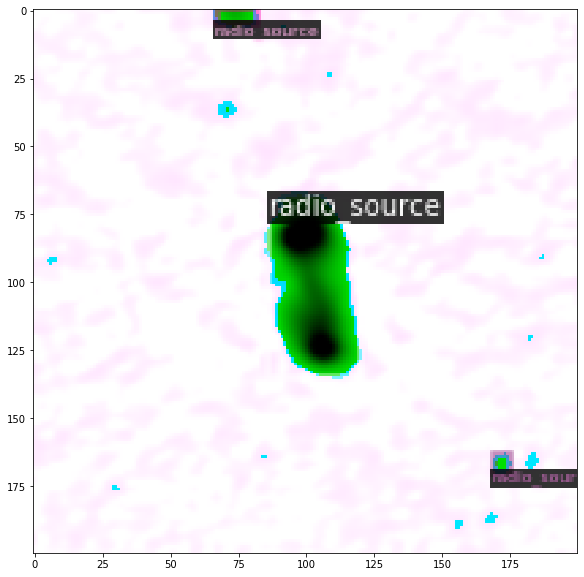

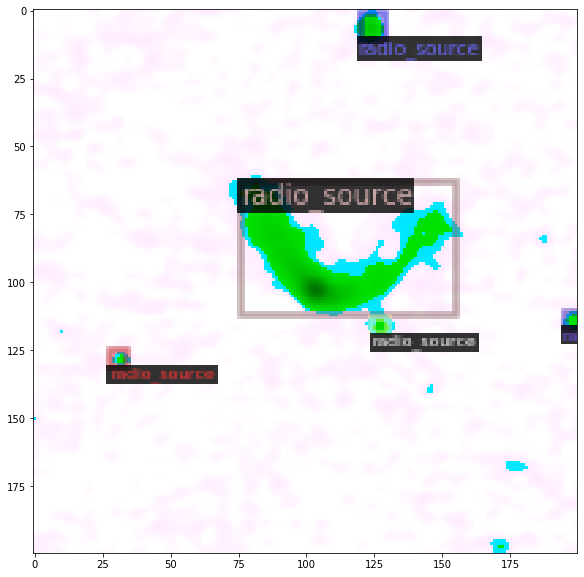

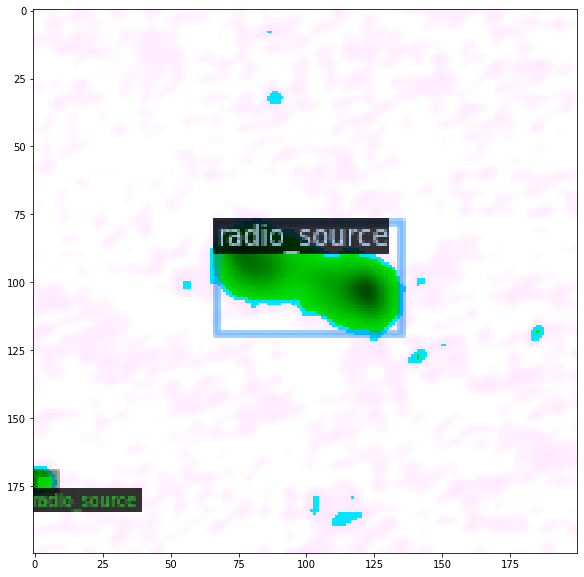

In [6]:
dataset_dicts = get_lofar_dicts(os.path.join(base_path,"VIA_json_test.pkl"))
for d in random.sample(dataset_dicts, 10):
#for d in dataset_dicts[:10]:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=lofar_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    a= vis.get_image()[:, :, ::-1]
    plt.figure(figsize=(10,10))
    plt.imshow(a)
    plt.show()

# Train mode

To implement the LOFAR relevant metrics I changed
DefaultTrainer into LOFARTrainer
where the latter calls LOFAREvaluator within build_hooks instead of the default evaluator
this works for the after the fact test eval
for train eval those things are somewhere within a model 
specifically a model that takes data and retuns a dict of losses

In [24]:
from detectron2.engine import DefaultTrainer, LOFARTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/v8_faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_train",)
cfg.DATASETS.VAL = (f"{DATASET_NAME}_val",)
cfg.DATASETS.TEST = (f"{DATASET_NAME}_test",)
cfg.DATALOADER.NUM_WORKERS = 1
cfg.OUTPUT_DIR = './output/v8'
#cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = None #"https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR,"model_0014999.pth")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0003  # pick a good LR
cfg.SOLVER.MAX_ITER = 100 # iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)
print(cfg.OUTPUT_DIR)

./output/v8


In [25]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = LOFARTrainer(cfg) 
trainer.resume_or_load(resume=True)

[02/11 13:13:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[02/11 13:13:43 d2.data.build]: Removed 0 images with no usable annotations. 3550 images left.
[02/11 13:13:44 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(600,), max_size=600, sample_style='choice'), RandomFlip()]
[02/11 13:13:44 d2.data.build]: Using training sampler TrainingSampler


In [ ]:
trainer.train()

[02/06 00:45:04 d2.engine.train_loop]: Starting training from iteration 0
[02/06 00:46:08 d2.utils.events]: eta: 4:51:33  iter: 19  total_loss: 1.795  loss_cls: 0.964  loss_box_reg: 0.013  loss_rpn_cls: 0.692  loss_rpn_loc: 0.096  time: 3.0256  data_time: 0.2118  lr: 0.000006  max_mem: 5003M
[02/06 00:47:15 d2.utils.events]: eta: 4:57:58  iter: 39  total_loss: 1.068  loss_cls: 0.240  loss_box_reg: 0.012  loss_rpn_cls: 0.688  loss_rpn_loc: 0.080  time: 3.1270  data_time: 0.3428  lr: 0.000012  max_mem: 5003M
[02/06 00:48:19 d2.utils.events]: eta: 4:52:13  iter: 59  total_loss: 0.884  loss_cls: 0.107  loss_box_reg: 0.014  loss_rpn_cls: 0.677  loss_rpn_loc: 0.074  time: 3.1421  data_time: 0.2620  lr: 0.000018  max_mem: 5003M
[02/06 00:49:22 d2.utils.events]: eta: 4:54:51  iter: 79  total_loss: 0.883  loss_cls: 0.087  loss_box_reg: 0.018  loss_rpn_cls: 0.665  loss_rpn_loc: 0.106  time: 3.1398  data_time: 0.2225  lr: 0.000024  max_mem: 5003M
[02/06 00:50:28 d2.utils.events]: eta: 4:53:01  it

[02/06 01:25:11 d2.utils.events]: eta: 4:23:50  iter: 739  total_loss: 0.335  loss_cls: 0.103  loss_box_reg: 0.141  loss_rpn_cls: 0.045  loss_rpn_loc: 0.039  time: 3.2266  data_time: 0.2595  lr: 0.000222  max_mem: 5003M
[02/06 01:26:17 d2.utils.events]: eta: 4:22:34  iter: 759  total_loss: 0.399  loss_cls: 0.119  loss_box_reg: 0.182  loss_rpn_cls: 0.043  loss_rpn_loc: 0.046  time: 3.2224  data_time: 0.1717  lr: 0.000228  max_mem: 5003M
[02/06 01:27:24 d2.utils.events]: eta: 4:21:36  iter: 779  total_loss: 0.405  loss_cls: 0.128  loss_box_reg: 0.171  loss_rpn_cls: 0.065  loss_rpn_loc: 0.037  time: 3.2260  data_time: 0.3848  lr: 0.000234  max_mem: 5003M
[02/06 01:28:28 d2.utils.events]: eta: 4:20:33  iter: 799  total_loss: 0.412  loss_cls: 0.129  loss_box_reg: 0.175  loss_rpn_cls: 0.055  loss_rpn_loc: 0.037  time: 3.2250  data_time: 0.2548  lr: 0.000240  max_mem: 5003M
[02/06 01:29:34 d2.utils.events]: eta: 4:19:30  iter: 819  total_loss: 0.334  loss_cls: 0.110  loss_box_reg: 0.157  loss

[02/06 02:04:34 d2.utils.events]: eta: 3:46:54  iter: 1459  total_loss: 0.313  loss_cls: 0.119  loss_box_reg: 0.142  loss_rpn_cls: 0.028  loss_rpn_loc: 0.022  time: 3.2349  data_time: 0.0461  lr: 0.000300  max_mem: 5003M
[02/06 02:05:48 d2.utils.events]: eta: 3:45:35  iter: 1479  total_loss: 0.334  loss_cls: 0.121  loss_box_reg: 0.178  loss_rpn_cls: 0.028  loss_rpn_loc: 0.026  time: 3.2406  data_time: 0.7646  lr: 0.000300  max_mem: 5003M
[02/06 02:06:49 d2.utils.events]: eta: 3:44:32  iter: 1499  total_loss: 0.342  loss_cls: 0.127  loss_box_reg: 0.188  loss_rpn_cls: 0.029  loss_rpn_loc: 0.019  time: 3.2380  data_time: 0.1820  lr: 0.000300  max_mem: 5003M
[02/06 02:07:55 d2.utils.events]: eta: 3:43:34  iter: 1519  total_loss: 0.345  loss_cls: 0.114  loss_box_reg: 0.184  loss_rpn_cls: 0.026  loss_rpn_loc: 0.024  time: 3.2389  data_time: 0.3421  lr: 0.000300  max_mem: 5003M
[02/06 02:08:54 d2.utils.events]: eta: 3:42:27  iter: 1539  total_loss: 0.414  loss_cls: 0.131  loss_box_reg: 0.186 

# Inference mode

In [26]:
cfg.OUTPUT_DIR

'./output/v8'

In [27]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0014999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set the testing threshold for this model
#cfg.DATASETS.TEST = (f"{DATASET_NAME}_", )
predictor = DefaultPredictor(cfg)

(200, 200, 3)
Instances(num_instances=2, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


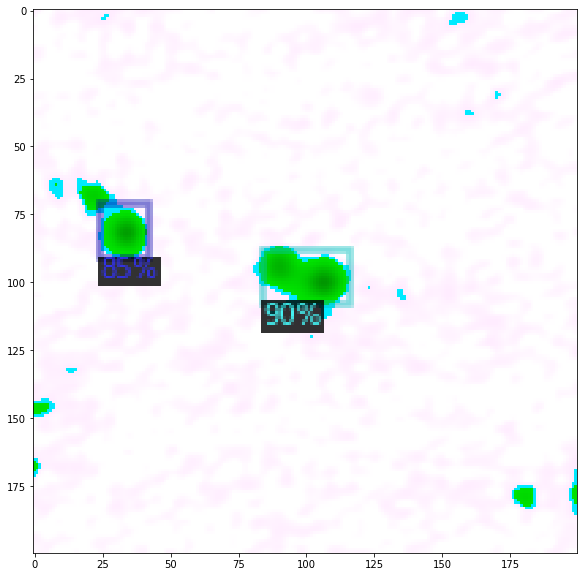

(200, 200, 3)
Instances(num_instances=1, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


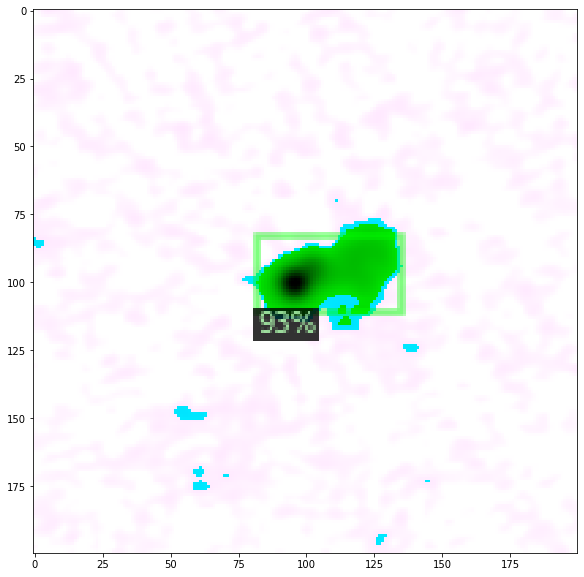

(200, 200, 3)
Instances(num_instances=1, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


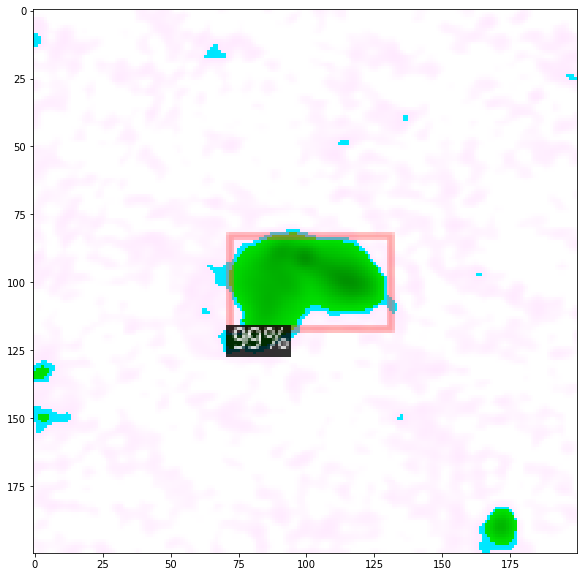

(200, 200, 3)
Instances(num_instances=1, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


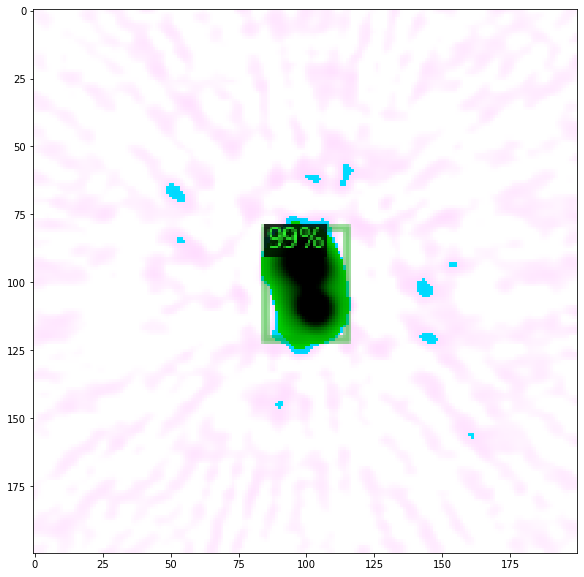

(200, 200, 3)
Instances(num_instances=1, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


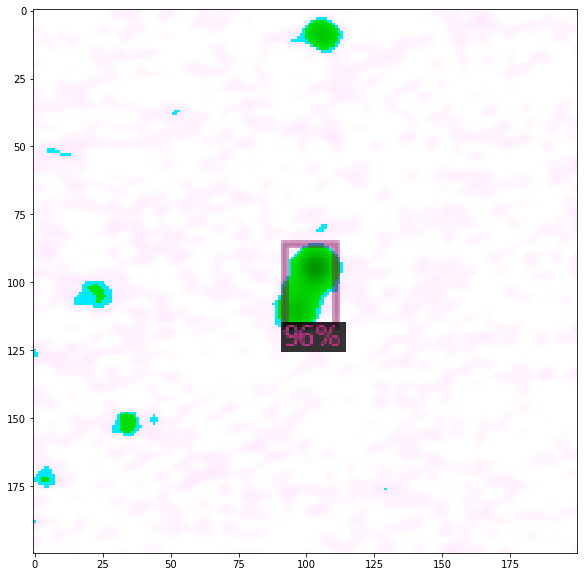

(200, 200, 3)
Instances(num_instances=1, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


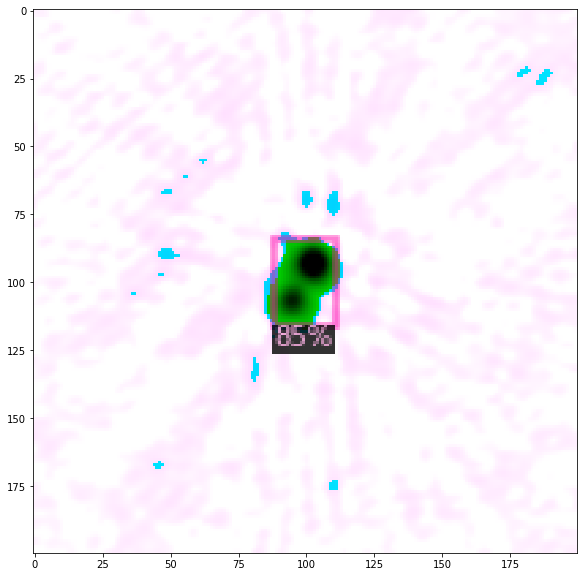

(200, 200, 3)
Instances(num_instances=1, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


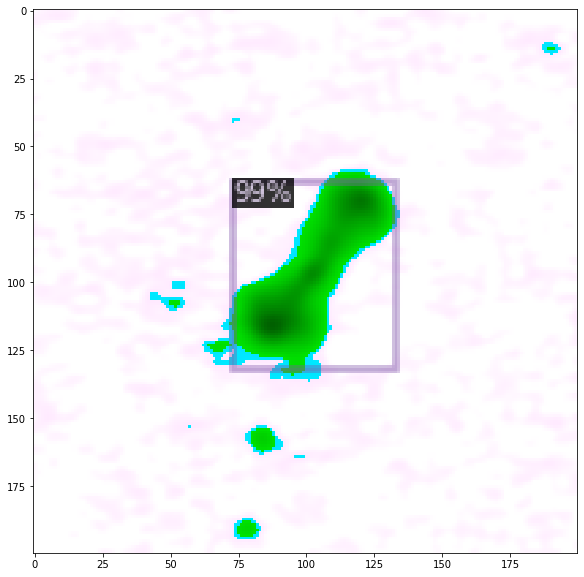

(200, 200, 3)
Instances(num_instances=1, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


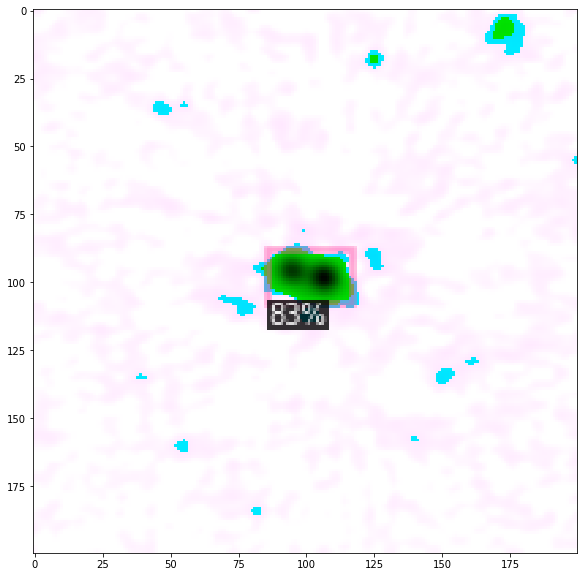

(200, 200, 3)
Instances(num_instances=1, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


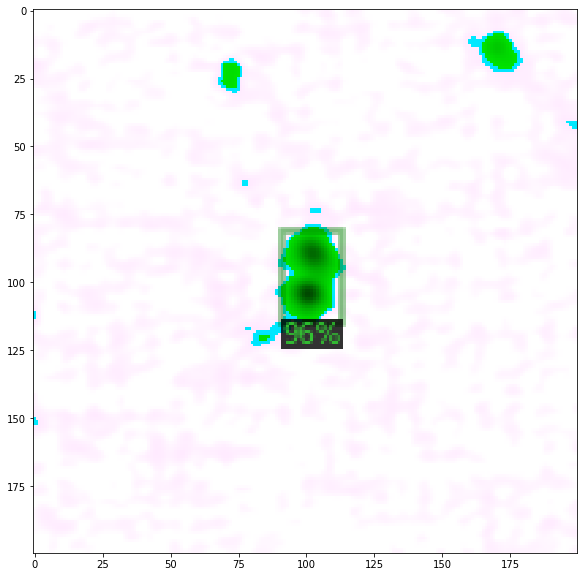

(200, 200, 3)
Instances(num_instances=1, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


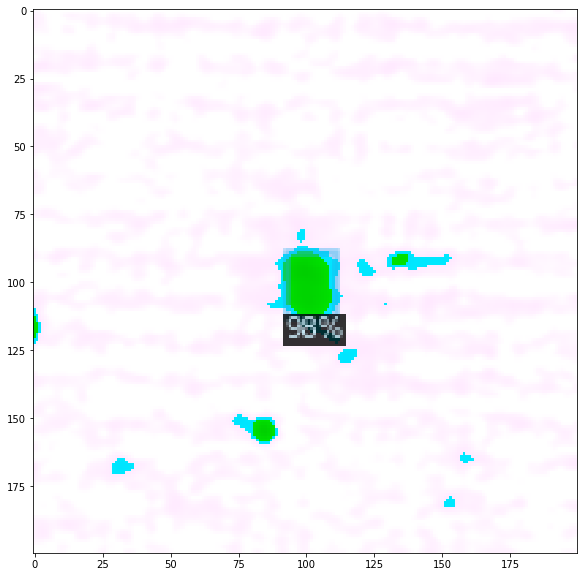

(200, 200, 3)
Instances(num_instances=1, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


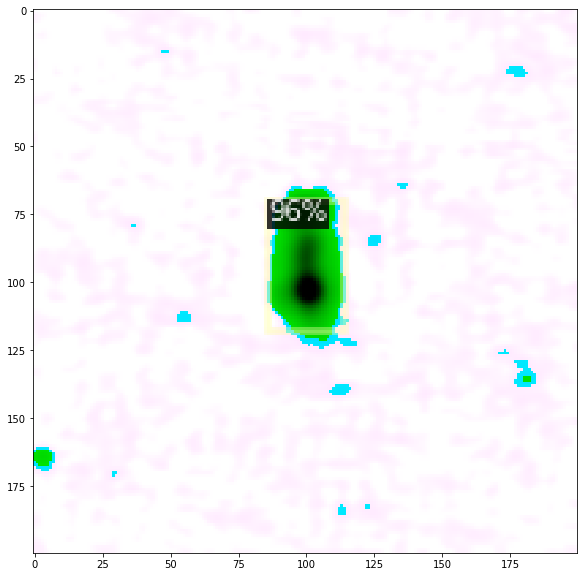

In [11]:
from detectron2.utils.visualizer import ColorMode
random.seed(5455)
aap = get_lofar_dicts(os.path.join(base_path,f"VIA_json_test.pkl"))
#for d in random.sample(aap, 30):
for i, d in enumerate(aap):
    if i > 10:
        break
    #print(d["file_name"])
    if not d["file_name"].endswith('_rotated0deg.png'):
        continue
    im = cv2.imread(d["file_name"])
    print(np.shape(im))
    outputs = predictor(im)
    print(outputs["instances"])
    v = Visualizer(im[:, :, ::-1],
                   metadata=lofar_metadata, 
                   scale=1, 
                  instance_mode=ColorMode.IMAGE #_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10,10))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

In [12]:
len(os.listdir(val_image_dir))

NameError: name 'val_image_dir' is not defined

In [29]:
#Val set evaluation
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LOFAREvaluator
from detectron2.data import build_detection_test_loader

# returns a torch DataLoader, that loads the given detection dataset, 
# with test-time transformation and batching.
val_loader = build_detection_test_loader(cfg, f"{DATASET_NAME}_val")

#evaluator = COCOEvaluator("lofar_data1_val", cfg, False, output_dir="./output/")
my_dataset = get_lofar_dicts(os.path.join(base_path,f"VIA_json_val.pkl"))

imsize = 200
evaluator = LOFAREvaluator(f"{DATASET_NAME}_val", cfg, False,imsize, gt_data=None, overwrite=True)
            
# Val_loader produces inputs that can enter the model for inference, 
# the results of which can be evaluated by the evaluator
# The return value is that which is returned by evaluator.evaluate()
predictions = inference_on_dataset(trainer.model, val_loader, evaluator, overwrite=False)

# Create evaluator
#1.28, 70.44, 8.83, 5.84
#1.16, 69.71, 9.64, 6.93

[02/11 13:14:43 d2.evaluation.evaluator]: Start inference on 1190 images
scale_factor 1.5151515151515151
check for dups 1190 1190 1190
There are 861 single component sources and 329 multi.
Thus 72% of the dataset is single component.
val_source_names val_fits_path
ILTJ135702.90+491909.7 /data/mostertrij/data/frcnn_images/cutouts/ILTJ135702.90+491909.7_radio_DR2.fits
Done saving (central) pixel locs.
Done saving neighbouring pixel locs.
ncomps locs, centrallocs, closecomplocs
2 (array([66.20009656, 46.44207002]), array([66.15058193, 47.42235783])) (array(66.20009656), array(66.15058193)) (array([122.68297255,  62.96327811,  33.31174643,  22.52450799,
        19.46507539,   5.1390105 ]), array([-13.17298681, 161.44179201, -50.62448561, -35.03288174,
       -49.95093788,  -2.58813299]))
len closecomplocs 1190 1190 1190 1190
pred_bboxes_scores
(array([[ 58.24285  ,  87.93967  , 112.3633   , 142.64938  ],
       [  7.4799075, 193.86845  ,  15.731865 , 199.78394  ],
       [ 56.12031  , 105.

In [31]:
#Test set evaluation
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LOFAREvaluator
from detectron2.data import build_detection_test_loader

# returns a torch DataLoader, that loads the given detection dataset, 
# with test-time transformation and batching.
test_loader = build_detection_test_loader(cfg, f"{DATASET_NAME}_test")

#evaluator = COCOEvaluator("lofar_data1_val", cfg, False, output_dir="./output/")
my_dataset = get_lofar_dicts(os.path.join(base_path,f"VIA_json_test.pkl"))
imsize = 200
evaluator = LOFAREvaluator(f"{DATASET_NAME}_test", cfg, False, imsize, gt_data=None, overwrite=False)
            
# Val_loader produces inputs that can enter the model for inference, 
# the results of which can be evaluated by the evaluator
# The return value is that which is returned by evaluator.evaluate()
predictions = inference_on_dataset(trainer.model, test_loader, evaluator, overwrite=False)

# Create evaluator

[02/11 13:28:23 d2.evaluation.evaluator]: Start inference on 1183 images
scale_factor 1.5151515151515151
val_source_names val_fits_path
ILTJ135711.85+485420.6 /data/mostertrij/data/frcnn_images/cutouts/ILTJ135711.85+485420.6_radio_DR2.fits
ncomps locs, centrallocs, closecomplocs
1 (array([66.28869248]), array([66.47221711])) (array(66.28869248), array(66.47221711)) (array([136.85096725, 136.13843312, 119.16225016, 101.55324147,
        36.63316329,  28.14496493,  22.27443417,  14.62822241,
         0.94026116,  -1.88567541, -10.71685856]), array([ 56.81718382,  14.28489563,  13.35746283, -51.08776615,
       -25.89984508, -50.18225595,  77.19111531,  86.1379233 ,
        34.88147347,  20.20227706, -35.93337829]))
len closecomplocs 1183 1183 1183 1183
pred_bboxes_scores
(array([[ 82.69477  ,  87.54466  , 116.03952  , 109.6625   ],
       [ 25.375126 ,  72.70032  ,  41.314457 ,  90.74953  ],
       [177.03006  , 175.78772  , 184.27997  , 182.8543   ],
       [ 17.604816 ,  64.57877  ,  2

In [23]:
Test
OrderedDict([('bbox', {'assoc_single_fail_fraction': 0.04367816091954024, 'assoc_multi_fail_fraction': 0.46006389776357826, 'unassoc_single_fail_fraction': 0.096551724137931, 'unassoc_multi_fail_fraction': 0.07987220447284349})])
OrderedDict([('bbox', {'assoc_single_fail_fraction': 0.04367816091954024, 'assoc_multi_fail_fraction': 0.46006389776357826, 'unassoc_single_fail_fraction': 0.096551724137931, 'unassoc_multi_fail_fraction': 0.07987220447284349})])
OrderedDict([('bbox', {'assoc_single_fail_fraction': 0.04367816091954024, 'assoc_multi_fail_fraction': 0.46006389776357826, 'unassoc_single_fail_fraction': 0.096551724137931, 'unassoc_multi_fail_fraction': 0.07987220447284349})])
{'assoc_single_fail_fraction': 0.005747126436781658, 'assoc_multi_fail_fraction': 0.30351437699680506, 'unassoc_single_fail_fraction': 0.08160919540229883, 'unassoc_multi_fail_fraction': 0.11182108626198084}
val
OrderedDict([('bbox', {'assoc_single_fail_fraction': 0.03948896631823462, 'assoc_multi_fail_fraction': 0.452887537993921, 'unassoc_single_fail_fraction': 0.08710801393728218, 'unassoc_multi_fail_fraction': 0.0820668693009119})])

NameError: name 'model' is not defined

In [28]:
[02/06 12:37:20 d2.evaluation.evaluator]: LOFAR Evaluation metrics (for all values 0% is best, 100% is worst):
[02/06 12:37:20 d2.evaluation.evaluator]: 1. Fraction of predictions that fail to cover a single component source.
[02/06 12:37:20 d2.evaluation.evaluator]: 0.23%
[02/06 12:37:20 d2.evaluation.evaluator]: 2. Fraction of predictions that fail to cover all components of a multi-component source.
[02/06 12:37:20 d2.evaluation.evaluator]: 28.57%
[02/06 12:37:20 d2.evaluation.evaluator]: 3. Fraction of predictions that include unassociated components for a single component source.
[02/06 12:37:20 d2.evaluation.evaluator]: 10.75%
[02/06 12:37:20 d2.evaluation.evaluator]: 4. Fraction of predictions that include unassociated components for a multi-component source.
[02/06 12:37:20 d2.evaluation.evaluator]: 10.96%

LGZ_v5_more_rotations


In [42]:
def baseline(single, multi):
    total = single + multi
    correct = single/total
    print(f"Baseline assumption cat is {correct:.1%} correct")
    return correct

def our_score(single, multi,score_dict, suffix=''):
    fail_single = score_dict['assoc_single_fail_fraction']*single + score_dict['unassoc_single_fail_fraction']*single
    fail_multi = score_dict['assoc_multi_fail_fraction']*multi + score_dict['unassoc_multi_fail_fraction']*multi
    total = single + multi
    correct = (total-(fail_single+fail_multi))/total
    print(correct)

    print(f"{suffix} cat is {correct:.1%} correct")
    return correct
def improv(baseline, our_score):
    print(f"{(our_score-baseline)/baseline:.2%} improvement")
    
test_score_dict = {'assoc_single_fail_fraction': 0.0012224938875305957, 'assoc_multi_fail_fraction': 0.3433242506811989, 
                   'unassoc_single_fail_fraction': 0.1136919315403423, 'unassoc_multi_fail_fraction': 0.10899182561307907}
test_norot_score_dict = {'assoc_single_fail_fraction': 0.005747126436781658, 'assoc_multi_fail_fraction': 0.30351437699680506, 
 'unassoc_single_fail_fraction': 0.08160919540229883, 'unassoc_multi_fail_fraction': 0.11182108626198084}
test_norot2 = {'assoc_single_fail_fraction': 0.0034482758620689724, 'assoc_multi_fail_fraction': 0.20127795527156545,
               'unassoc_single_fail_fraction': 0.11264367816091958, 'unassoc_multi_fail_fraction': 0.13418530351437696}
test_rot_score_dict = {'assoc_single_fail_fraction': 0.0045977011494252595, 'assoc_multi_fail_fraction': 0.207667731629393, 
                    'unassoc_single_fail_fraction': 0.10919540229885061, 'unassoc_multi_fail_fraction': 0.12779552715654952}
test_v7 = {'assoc_single_fail_fraction': 0.0034482758620689724, 'assoc_multi_fail_fraction': 0.20127795527156545,
 'unassoc_single_fail_fraction': 0.11264367816091958, 'unassoc_multi_fail_fraction': 0.13418530351437696}
optimal_score_dict = {'assoc_single_fail_fraction': 0.0, 'assoc_multi_fail_fraction': 0.04792332268370603, 
                   'unassoc_single_fail_fraction': 0.07241379310344831, 'unassoc_multi_fail_fraction': 0.12460063897763574}

single, multi = 870,313
baseline = baseline(single, multi)
optimal_score = our_score(single, multi, optimal_score_dict, suffix='optimal test')
our_score1 = our_score(single, multi,test_score_dict,suffix='our test')
our_score2 = our_score(single, multi,test_norot_score_dict,suffix='our new test norot')
our_score3 = our_score(single, multi,test_rot_score_dict,suffix='our new test rot')
our_score4 = our_score(single, multi,test_v7,suffix='our test v7')
improv(baseline, our_score1)
improv(baseline, our_score2)
improv(baseline, our_score3)
improv(baseline, our_score4)

Baseline assumption cat is 73.5% correct
0.9010989010989011
optimal test cat is 90.1% correct
0.7958153152980909
our test cat is 79.6% correct
0.8258664412510567
our new test norot cat is 82.6% correct
0.8275570583262891
our new test rot cat is 82.8% correct
0.8258664412510567
our test v7 cat is 82.6% correct
8.21% improvement
12.30% improvement
12.53% improvement
12.30% improvement
